# PS1-5 Locally Weighted Linear Regression

In [119]:
import numpy as np
import src.util as util
from src.linear_model import LinearModel
import matplotlib.pyplot as plt

In [120]:
ds5_train_path = './data/ds5_train.csv'
ds5_val_path = './data/ds5_valid.csv'
ds5_test_path = './data/ds5_test.csv'
p05c_pred_path = './output/p05c_pred.txt'

In [121]:
x_train, y_train = util.load_dataset(ds5_train_path, add_intercept=True)
x_val, y_val = util.load_dataset(ds5_val_path, add_intercept=True)
x_test, y_test = util.load_dataset(ds5_test_path, add_intercept=True)

### (a) Theoretical derivation.

#### (i) Matrix form of the objective function.

Let $W=(w_{ij})_{m\times m}$, then we obtain

\begin{align*}
(X\theta-y)^TW(X\theta-y)=\sum_{j=1}^m\sum_{i=1}^mw_{ij}(x^{(j)}\theta-y^{(j)})(x^{(i)}\theta-y^{(i)}).
\end{align*}

Therefore, $J(\theta) = (X\theta-y)^TW(X\theta-y)$ if we define $w_{ij}=\frac{1}{2}\delta_{ij}w^{(i)}$, where $\delta_{ij}$ is the Kronecker symbol. 

That's to say $W=\mathrm{diag}\{\frac{1}{2}w^{(1)}, \frac{1}{2}w^{(2)},\dots, \frac{1}{2}w^{(m)}\}$.

#### (ii) Solve for $\theta$.

From (i) we can obtain the gradient of $J(\theta)$ w.r.t. $\theta$:

\begin{align*}
\nabla_\theta J(\theta) &= \nabla_\theta (X\theta-y)^TW(X\theta-y) \\
&=\nabla_\theta(\theta^TX^TWX\theta - \theta^TX^TWy-y^TWX\theta+y^TWy) \\
&=2X^TWX\theta-X^TWy-X^TWy \\
&=2(X^TWX\theta - X^TWy).
\end{align*}

Set the gradient to zero, we have

\begin{align*}
X^TWX\theta = X^TWy.
\end{align*}

Therefore, the solution is given by

\begin{align*}
\theta = (X^TWX)^{-1}X^TWy.
\end{align*}

#### (iii) Define a locally weighted linear regression problem.

The log-likelihood is given by

\begin{align*}
l(\theta) &= \sum_{i=1}^m \ln \frac{1}{\sqrt{2\pi}\sigma^{(i)}} + \sum_{i=1}^m \frac{-(y^{(i)} - \theta^Tx^{(i)})^2}{2(\sigma^{(i)})^2} 
\end{align*}

The first term is a constant, so maximizing the log-likelihood is equivalent to maximizing the second term. Therefore, 
\begin{align*}
\theta &= \argmax_\theta \sum_{i=1}^m \frac{-(y^{(i)} - \theta^Tx^{(i)})^2}{2(\sigma^{(i)})^2} \\
&= \argmin_\theta \frac{1}{2}\sum_{i=1}^m\frac{1}{(\sigma^{(i)})^2}(y^{(i)} - \theta^Tx^{(i)})^2 \\
&= \argmin_\theta \frac{1}{2}\sum_{i=1}^m \frac{1}{(\sigma^{(i)})^2}(\theta^Tx^{(i)} - y^{(i)})^2.
\end{align*}

Thus, MLE of $\theta$ reduces to solving a weighted linear regression problem, where $w^{(i)}=\frac{1}{(\sigma^{(i)})^2}$.

### (b) Implement locally weighted linear regression.

Codes below are modified from `./src/p05b_lwr.py`.

In [122]:
class LocallyWeightedLinearRegression(LinearModel):
    """Locally Weighted Regression (LWR).

    Example usage:
        > clf = LocallyWeightedLinearRegression(tau)
        > clf.fit(x_train, y_train)
        > clf.predict(x_eval)
    """

    def __init__(self, tau):
        super(LocallyWeightedLinearRegression, self).__init__()
        self.tau = tau
        self.x = None
        self.y = None

    def fit(self, x, y):
        """Fit LWR by saving the training set.

        Args:
            x: Inputs of shape (m1, n).
            y: Outputs of shape (m1,).

        """
        # *** START CODE HERE ***
        self.x = x.copy()   # shape (m1, n)
        self.y = y.copy()   # shape (m1,)
        # *** END CODE HERE ***

    def predict(self, x):
        """Make predictions given inputs x.

        Args:
            x: Inputs of shape (m2, n).

        Returns:
            Outputs of shape (m2,).
        """
        # *** START CODE HERE ***
        # calculate the weights for each training point based on the distance to the input x
        # parallel through broadcasting
        diff_x = x[:, np.newaxis, :] - self.x[np.newaxis, :, :]  # shape (m2, m1, n)
        W_vec = np.exp(-np.sum(diff_x**2, axis=2) / (2 * self.tau**2)) # shape (m2, m1)
        W = np.apply_along_axis(np.diag, axis=1, arr=W_vec) # shape (m2, m1, m1)

        # solve theta using the normal equation for each x
        theta = np.linalg.inv(self.x.T @ W @ self.x) @ (self.x.T @ W @ self.y.reshape(-1, 1))  # shape (m2, n, 1)
        y_pred = x[:, np.newaxis, :] @ theta  # shape (m2, 1, 1)
        return y_pred.flatten()
        # *** END CODE HERE ***


In [123]:
lwr_clf = LocallyWeightedLinearRegression(tau=0.5)
lwr_clf.fit(x_train, y_train)

In [124]:
y_val_pred = lwr_clf.predict(x_val)
mse_err = np.mean((y_val - y_val_pred)**2)
print(f"Validation MSE: {mse_err:.4f}")

Validation MSE: 0.3305


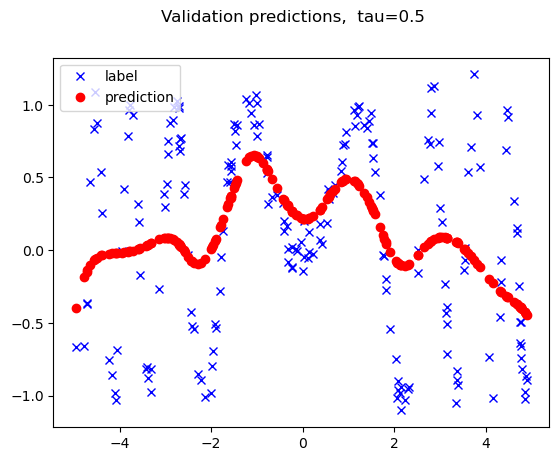

In [125]:
def plot(x, y_label, y_pred, title):
    plt.figure()
    plt.plot(x[:,-1], y_label, 'bx', label='label')
    plt.plot(x[:,-1], y_pred, 'ro', label='prediction')
    plt.suptitle(title, fontsize=12)
    plt.legend(loc='upper left')
plot(x_val, y_val, y_val_pred, f'Validation predictions,  tau={lwr_clf.tau}')

The model is underfitting.

### (d) Tune the hyperparameter $\tau$.

tau = 0.03
Validation MSE: 0.0181
tau = 0.05
Validation MSE: 0.0124
tau = 0.1
Validation MSE: 0.0242
tau = 0.5
Validation MSE: 0.3305
tau = 1.0
Validation MSE: 0.4001
tau = 10.0
Validation MSE: 0.4337
Min validation MSE: 0.0124


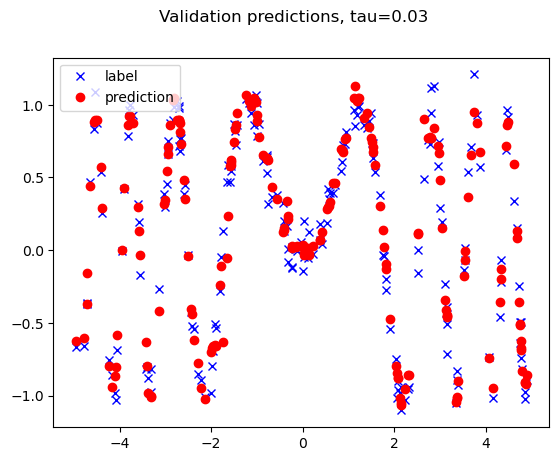

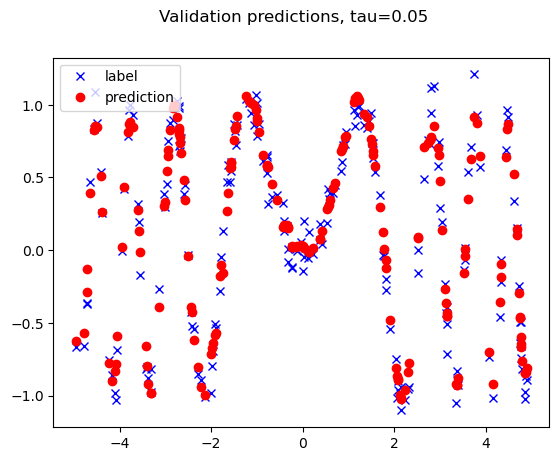

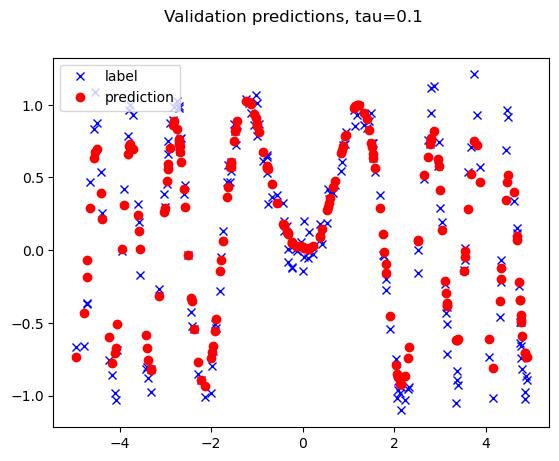

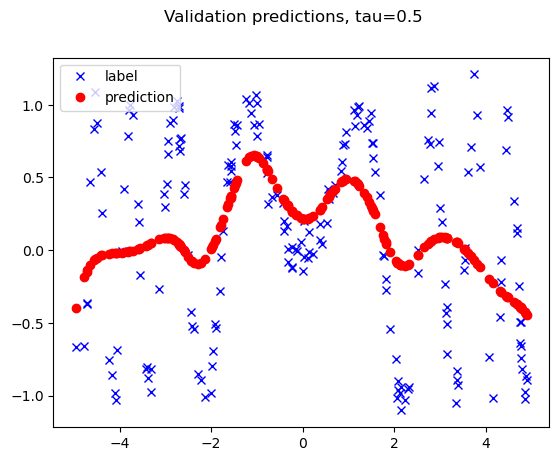

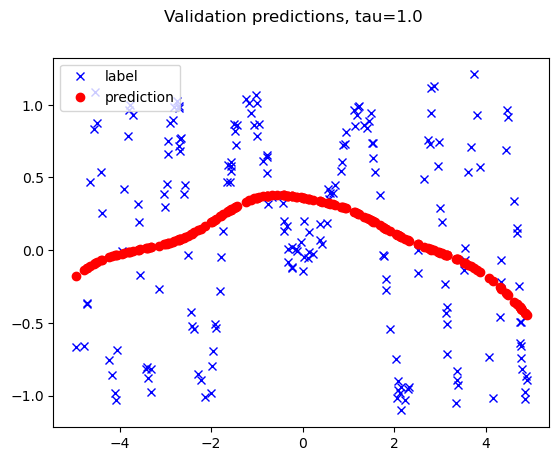

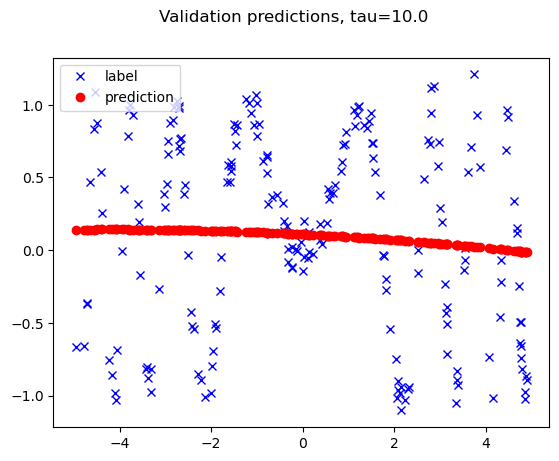

In [126]:
min_mse_err = np.inf
for tau in [3e-2, 5e-2, 1e-1, 5e-1, 1e0, 1e1]:
    print(f'tau = {tau}')
    lwr_clf = LocallyWeightedLinearRegression(tau=tau)
    lwr_clf.fit(x_train, y_train)
    y_val_pred = lwr_clf.predict(x_val)
    mse_err = np.mean((y_val - y_val_pred)**2)
    print(f"Validation MSE: {mse_err:.4f}")
    min_mse_err = min(min_mse_err, mse_err)
    plot(x_val, y_val, y_val_pred, f'Validation predictions, tau={lwr_clf.tau}')
print(f"Min validation MSE: {min_mse_err:.4f}")

$\tau = 0.05$ leads to the lowest MSE on the validation set.

In [127]:
lwr_clf = LocallyWeightedLinearRegression(tau=0.05)
lwr_clf.fit(x_train, y_train)
y_test_pred = lwr_clf.predict(x_test)
np.savetxt(p05c_pred_path, y_test_pred)
mse_err = np.mean((y_test - y_test_pred)**2)
print(f"Test MSE: {mse_err:.4f}")

Test MSE: 0.0170
